# Imports

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import seaborn as sns

In [3]:
import torchvision

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import cv2

In [6]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam

In [8]:
from torch.utils.data import random_split

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [10]:
from sklearn.metrics import confusion_matrix

# Data Loading

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
])

In [12]:
train_data = datasets.ImageFolder(root='/kaggle/input/skin-cancer-malignant-vs-benign/train', transform=transform)
test_data = datasets.ImageFolder(root='/kaggle/input/skin-cancer-malignant-vs-benign/test', transform=transform)

In [13]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Functions

In [14]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [15]:
def show_examples(loader, class_names, num_examples=4):
    for dataiter in loader:
        images, labels = dataiter
        
        benign_images = images[labels == 0][:num_examples]
        malignant_images = images[labels == 1][:num_examples]
        
        if len(benign_images) > 0 and len(malignant_images) > 0:
            print(f'Exemplos de imagens benignas (Classe: {class_names[0]})')
            imshow(torchvision.utils.make_grid(benign_images))

            print(f'Exemplos de imagens malignas (Classe: {class_names[1]})')
            imshow(torchvision.utils.make_grid(malignant_images))
            break  
        


In [16]:
def plot_color_histogram(image_path):
    image = cv2.imread(image_path)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    colors = ('r', 'g', 'b')
    channel_ids = (0, 1, 2)
    
    plt.figure(figsize=(10, 5))
    for channel_id, color in zip(channel_ids, colors):
        hist = cv2.calcHist([image_rgb], [channel_id], None, [256], [0, 256])
        plt.plot(hist, color=color)
    
    plt.title('Color Intensity Histogram')
    plt.xlabel('Color Intensity')
    plt.ylabel('Frequency')
    plt.show()

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, lr, save_metrics=True):
    
    
    

    history = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    for epoch in range(num_epochs):
        # --- Treinamento ---
        model.train()
        train_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')

        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_precision = precision_score(all_labels, all_preds, average='weighted')
        val_recall = recall_score(all_labels, all_preds, average='weighted')

        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train - Loss: {history["train_loss"][-1]:.4f}, Acc: {history["train_acc"][-1]:.4f}, F1: {history["train_f1"][-1]:.4f}, Precision: {history["train_precision"][-1]:.4f}, Recall: {history["train_recall"][-1]:.4f}')
        print(f'Val   - Loss: {history["val_loss"][-1]:.4f}, Acc: {history["val_acc"][-1]:.4f}, F1: {history["val_f1"][-1]:.4f}, Precision: {history["val_precision"][-1]:.4f}, Recall: {history["val_recall"][-1]:.4f}')
    
    if save_metrics:
        torch.save(history, 'training_history.pth')
    
    return history

In [18]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1-score over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Val Precision')
    plt.title('Precision over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Val Recall')
    plt.title('Recall over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [19]:
def test_model_with_metrics(model, test_loader):
    model.eval()  
    correct = 0
    total = 0
    test_loss = 0.0

    all_preds = []
    all_labels = []

    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            
            outputs = model(inputs)

            
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())    

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    
    return accuracy, precision, recall, f1


In [20]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# EDA

In [21]:
class_names = train_data.classes
class_counts = [len(os.listdir(os.path.join('/kaggle/input/skin-cancer-malignant-vs-benign/train', cls))) for cls in class_names]

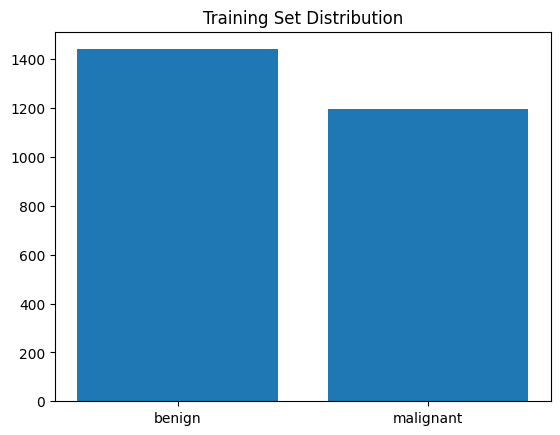

In [22]:
plt.bar(class_names, class_counts)
plt.title('Training Set Distribution')
plt.show()

In [23]:
class_counts = [len(os.listdir(os.path.join('/kaggle/input/skin-cancer-malignant-vs-benign/test', cls))) for cls in class_names]

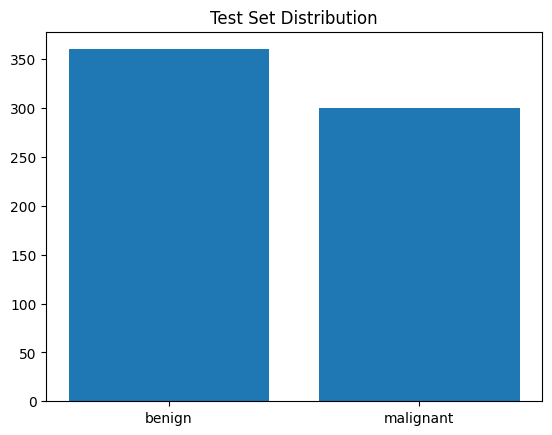

In [24]:
plt.bar(class_names, class_counts)
plt.title('Test Set Distribution')
plt.show()

Training Examples:
Exemplos de imagens benignas (Classe: benign)


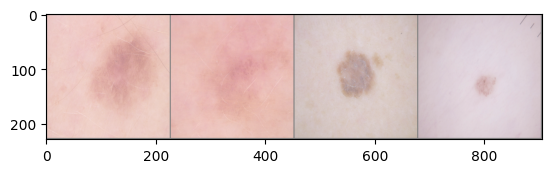

Exemplos de imagens malignas (Classe: malignant)


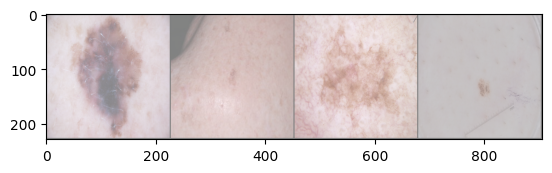

In [25]:
print("Training Examples:")
show_examples(train_loader, class_names)

Test Examples::
Exemplos de imagens benignas (Classe: benign)


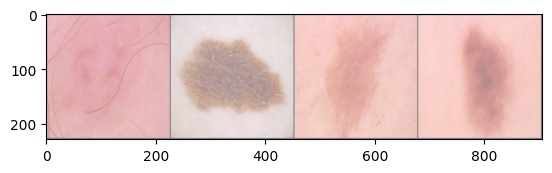

Exemplos de imagens malignas (Classe: malignant)


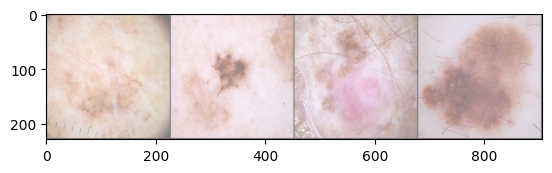

In [26]:
print("Test Examples::")
show_examples(test_loader, class_names)

In [27]:
sample_image_path_benign = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1029.jpg'

In [28]:
sample_image_path_malignant = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1022.jpg'

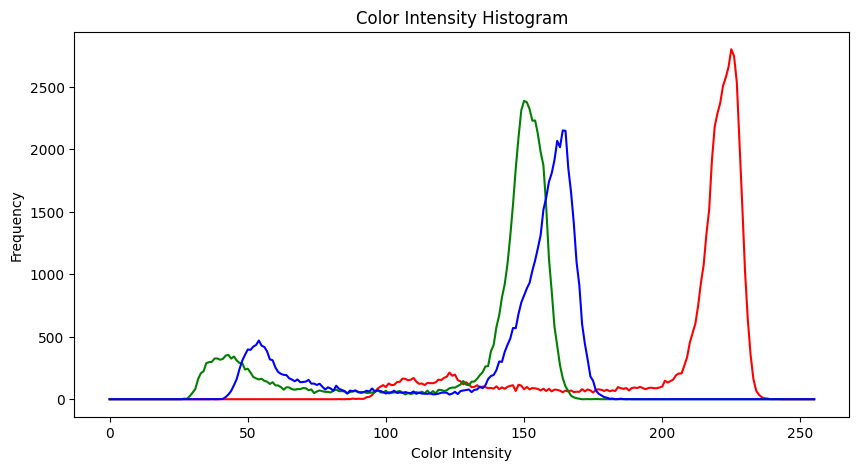

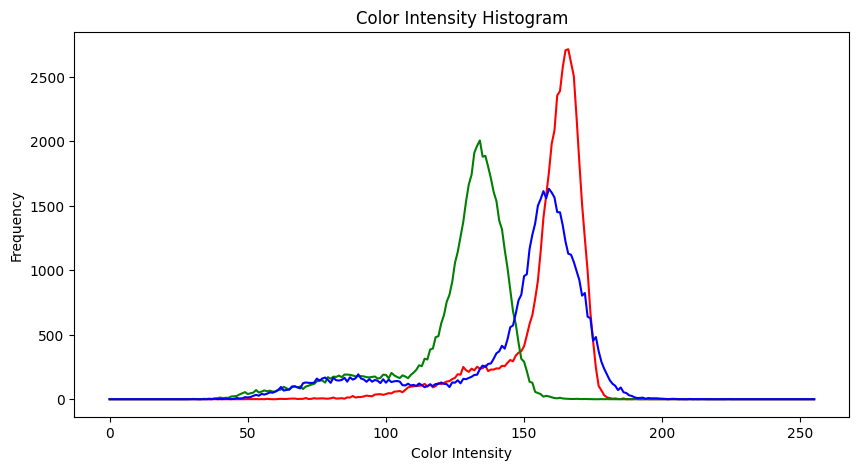

In [29]:
plot_color_histogram(sample_image_path_benign)
plot_color_histogram(sample_image_path_malignant)


# Data Preprocessing/Augmentation

In [30]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [31]:
test_transforms = transforms.Compose([
    transforms.Resize(256),                       
    transforms.CenterCrop(224),                   
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [32]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/skin-cancer-malignant-vs-benign/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='/kaggle/input/skin-cancer-malignant-vs-benign/test', transform=test_transforms)

In [33]:
train_size = int(0.8 * len(train_dataset))  # 80% treino
val_size = len(train_dataset) - train_size  # 20% validação

In [34]:
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [35]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# EfficientNet Model

In [36]:
model = models.efficientnet_b0(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.4MB/s]


In [37]:
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},  
    {'params': model.classifier.parameters(), 'lr': 1e-3}  
])


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [40]:
history = train_model(model, train_loader, val_loader,criterion,optimizer, num_epochs=15, lr = 0.001)


Epoch [1/15]
Train - Loss: 0.5160, Acc: 0.7297, F1: 0.7300, Precision: 0.7308, Recall: 0.7297
Val   - Loss: 0.3895, Acc: 0.8144, F1: 0.8146, Precision: 0.8148, Recall: 0.8144
Epoch [2/15]
Train - Loss: 0.4144, Acc: 0.8042, F1: 0.8045, Precision: 0.8075, Recall: 0.8042
Val   - Loss: 0.3739, Acc: 0.8201, F1: 0.8191, Precision: 0.8199, Recall: 0.8201
Epoch [3/15]
Train - Loss: 0.3912, Acc: 0.8122, F1: 0.8124, Precision: 0.8130, Recall: 0.8122
Val   - Loss: 0.3342, Acc: 0.8447, F1: 0.8452, Precision: 0.8477, Recall: 0.8447
Epoch [4/15]
Train - Loss: 0.3790, Acc: 0.8331, F1: 0.8333, Precision: 0.8346, Recall: 0.8331
Val   - Loss: 0.3103, Acc: 0.8693, F1: 0.8695, Precision: 0.8700, Recall: 0.8693
Epoch [5/15]
Train - Loss: 0.3773, Acc: 0.8255, F1: 0.8258, Precision: 0.8276, Recall: 0.8255
Val   - Loss: 0.3309, Acc: 0.8617, F1: 0.8621, Precision: 0.8631, Recall: 0.8617
Epoch [6/15]
Train - Loss: 0.3790, Acc: 0.8179, F1: 0.8182, Precision: 0.8201, Recall: 0.8179
Val   - Loss: 0.3002, Acc: 0.85

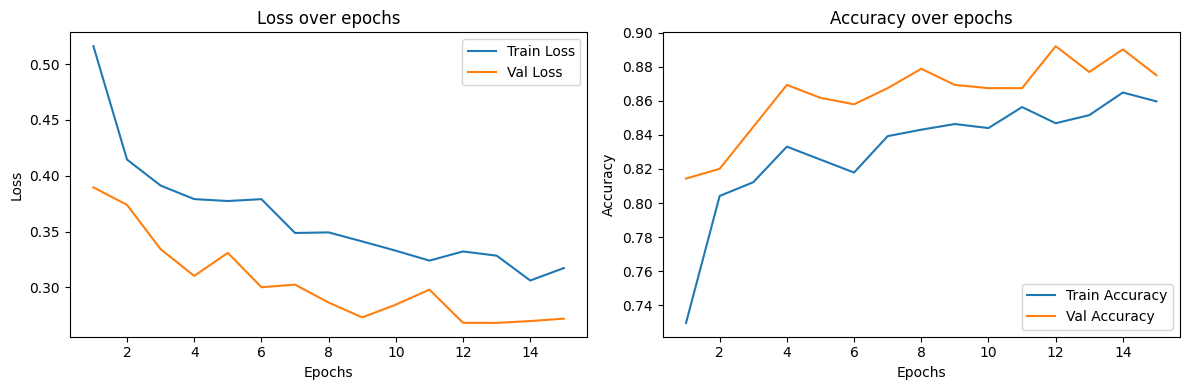

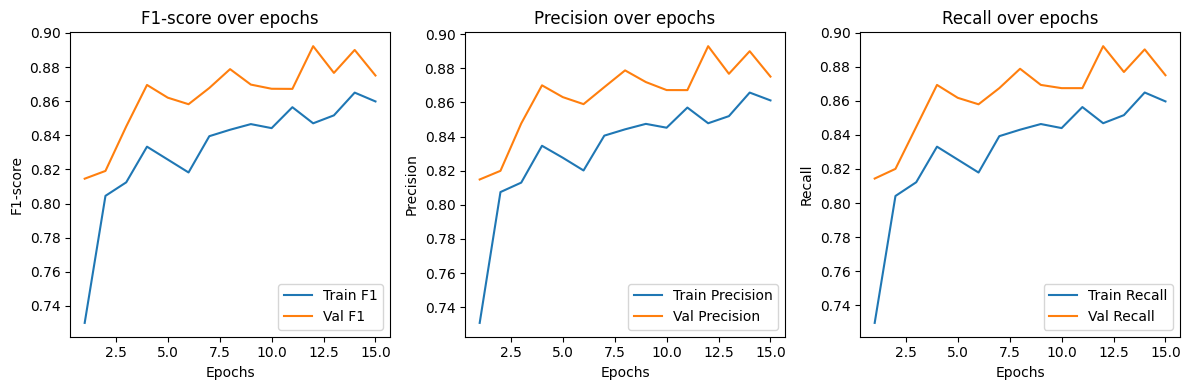

In [41]:
plot_metrics(history)

In [42]:
accuracy, precision, recall, f1 = test_model_with_metrics(model, test_loader)

Test Loss: 0.3079
Test Accuracy: 85.91%
Precision: 0.8650
Recall: 0.8591
F1-Score: 0.8594


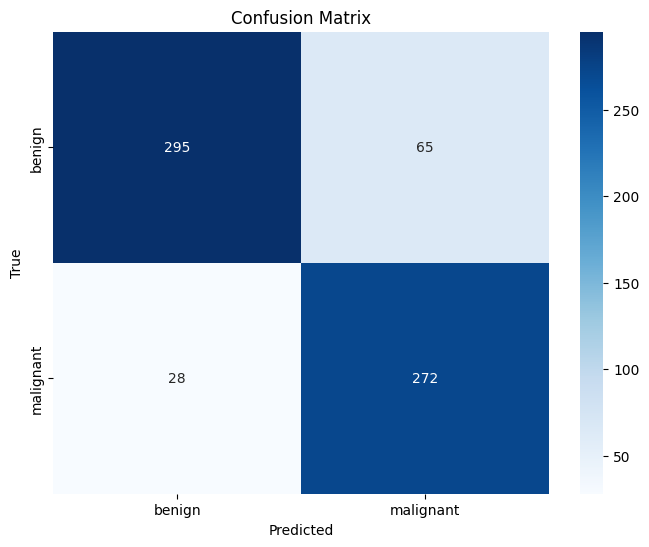

In [43]:
plot_confusion_matrix(model, test_loader, class_names)